In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
data_dir = "/Users/diananigmatullina/Downloads/data_thesis"  
all_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv.gz")])

df_list = []

for file in all_files:
    df_tmp = pd.read_csv(file)

    # Keep only top 5 levels
    keep_cols = ['timestamp', 'local_timestamp', 'exchange', 'symbol']
    for i in range(5):
        keep_cols += [f'asks[{i}].price', f'asks[{i}].amount', f'bids[{i}].price', f'bids[{i}].amount']
    
    df_tmp = df_tmp[keep_cols]
    df_list.append(df_tmp)

df = pd.concat(df_list, ignore_index=True)

In [6]:
df["spread"] = df["asks[0].price"] - df["bids[0].price"]
df["total_ask_volume"] = sum(df[f"asks[{i}].amount"] for i in range(5))
df["total_bid_volume"] = sum(df[f"bids[{i}].amount"] for i in range(5))

In [7]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

In [9]:
df["order_imbalance"] = (df["total_bid_volume"] - df["total_ask_volume"]) / (
    df["total_bid_volume"] + df["total_ask_volume"] + 1e-8
)
df["mid_price"] = (df["asks[0].price"] + df["bids[0].price"]) / 2
df["log_return"] = np.log(df["mid_price"] / df["mid_price"].shift(1))
df["rolling_volatility"] = df["log_return"].rolling(window=100).std()
df['mid_return'] = df['mid_price'].pct_change().fillna(0)

In [28]:
class StableBaselinesTradingEnvironment(gym.Env):
    def __init__(self, env_config):
        super().__init__()
        self.inner_env = DogeQuoteEnv(env_config)
        self.action_space = self.inner_env.action_space
        self.observation_space = self.inner_env.observation_space

    def reset(self, *, seed=None, options=None):
        obs, info = self.inner_env.reset(seed=seed, options=options)
        return obs, info

    def step(self, action):
        return self.inner_env.step(action)

    def render(self):
        self.inner_env.render()

    @property
    def pnl_history(self):
        return self.inner_env.pnl_history

    @property
    def inventory_history(self):
        return self.inner_env.inventory_history

In [34]:
class DogeQuoteEnv(gym.Env):
    def __init__(self, config):
        self.df = config["df"]
        self.step_idx = 0
        self.inventory = 0
        self.balance = 1000.0
        self.max_inventory = 10
        self.prev_pnl = self.balance
        self.fee = 0.001
        self.phi = 0.1  # running inventory penalty
        self.alpha = 0.01  # terminal inventory penalty

        self.action_map = {
            0: (0.001, 0.001),
            1: (0.002, 0.002),
            2: (0.003, 0.003),
            3: (0.004, 0.004),
            4: (0.005, 0.005),
        }
        self.action_space = spaces.Discrete(len(self.action_map))

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self._get_obs()),), dtype=np.float32
        )

        self.pnl_history = []
        self.inventory_history = []

    def _fill_probability(self, price_distance):
        return np.exp(-50 * price_distance)

    def _get_obs(self):
        row = self.df.iloc[self.step_idx]
        return np.array([
            row['mid_price'],
            self.inventory,
        ])

    def step(self, action):
        action = int(np.asarray(action).item())  # handles nested arrays too
        bid_offset, ask_offset = self.action_map[action]

        row = self.df.iloc[self.step_idx]
        mid_price = row['mid_price']
        bid_price = mid_price - bid_offset
        ask_price = mid_price + ask_offset
        market_bid = row['bids[0].price']
        market_ask = row['asks[0].price']

        filled_bid = False
        filled_ask = False

        if self.inventory < self.max_inventory and self.balance >= bid_price:
            prob = self._fill_probability(abs(market_ask - bid_price))
            if np.random.rand() < prob:
                self.inventory += 1
                self.balance -= bid_price * (1 + self.fee)
                filled_bid = True

        if self.inventory > -self.max_inventory:
            prob = self._fill_probability(abs(ask_price - market_bid))
            if np.random.rand() < prob:
                self.inventory -= 1
                self.balance += ask_price * (1 - self.fee)
                filled_ask = True

        self.step_idx += 1
        done = self.step_idx >= len(self.df) - 1

        next_mid = self.df.iloc[self.step_idx]['mid_price']
        net_worth = self.balance + self.inventory * next_mid
        incremental_reward = (net_worth - self.prev_pnl)
        self.prev_pnl = net_worth

        realized_spread = 0
        if filled_bid:
            realized_spread += market_ask - bid_price
        if filled_ask:
            realized_spread += ask_price - market_bid

        running_penalty = self.phi * self.inventory**2 + 0.3 * abs(self.inventory)
        terminal_penalty = self.alpha * self.inventory**2 if done else 0

        reward = (incremental_reward + realized_spread - running_penalty - terminal_penalty) / 10.0

        self.pnl_history.append(net_worth)
        self.inventory_history.append(self.inventory)

        return self._get_obs(), reward, done, False, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_idx = 0
        self.inventory = 0
        self.balance = 1000.0
        self.prev_pnl = self.balance
        self.pnl_history = []
        self.inventory_history = []
        return self._get_obs(), {}

    def render(self):
        print(f"Step {self.step_idx} | Balance: {self.balance:.2f} | Inventory: {self.inventory}")

In [36]:
env_config = {"df": df}
env = DummyVecEnv([lambda: StableBaselinesTradingEnvironment(env_config)])
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=500_000)
model.save("dqn_mbt_style_market_maker")

env_instance = env.envs[0]
obs, _ = env_instance.reset()
done = False
max_steps = 1000 # can't handle all steps, trying on limit number
step_count = 0
while not done and step_count < max_steps:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env_instance.step(action)
    env_instance.render()
    step_count += 1

Using cpu device
Step 1 | Balance: 1000.00 | Inventory: 0
Step 2 | Balance: 1000.00 | Inventory: 0
Step 3 | Balance: 1000.00 | Inventory: 0
Step 4 | Balance: 1000.32 | Inventory: -1
Step 5 | Balance: 1000.33 | Inventory: -1
Step 6 | Balance: 1000.33 | Inventory: -1
Step 7 | Balance: 1000.34 | Inventory: -1
Step 8 | Balance: 1000.34 | Inventory: -1
Step 9 | Balance: 1000.35 | Inventory: -1
Step 10 | Balance: 1000.35 | Inventory: -1
Step 11 | Balance: 1000.36 | Inventory: -1
Step 12 | Balance: 1000.36 | Inventory: -1
Step 13 | Balance: 1000.37 | Inventory: -1
Step 14 | Balance: 1000.37 | Inventory: -1
Step 15 | Balance: 1000.38 | Inventory: -1
Step 16 | Balance: 1000.39 | Inventory: -1
Step 17 | Balance: 1000.39 | Inventory: -1
Step 18 | Balance: 1000.40 | Inventory: -1
Step 19 | Balance: 1000.40 | Inventory: -1
Step 20 | Balance: 1000.41 | Inventory: -1
Step 21 | Balance: 1000.41 | Inventory: -1
Step 22 | Balance: 1000.42 | Inventory: -1
Step 23 | Balance: 1000.42 | Inventory: -1
Step 2

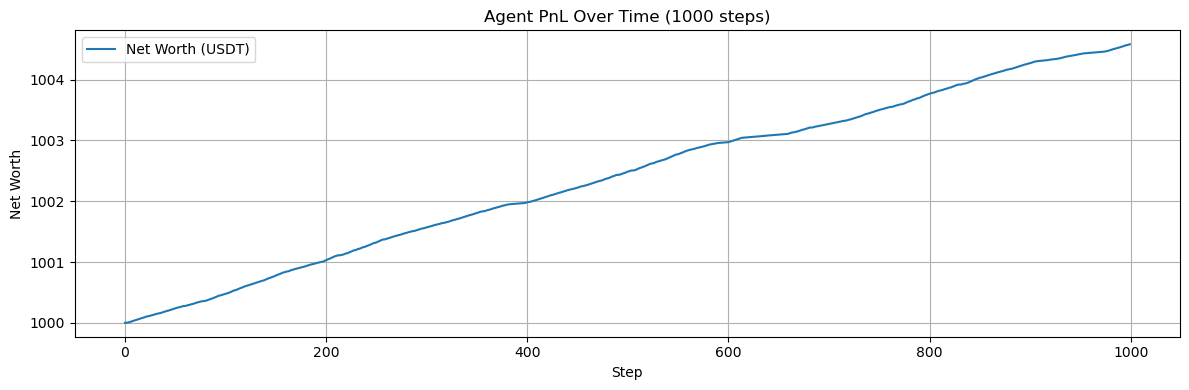

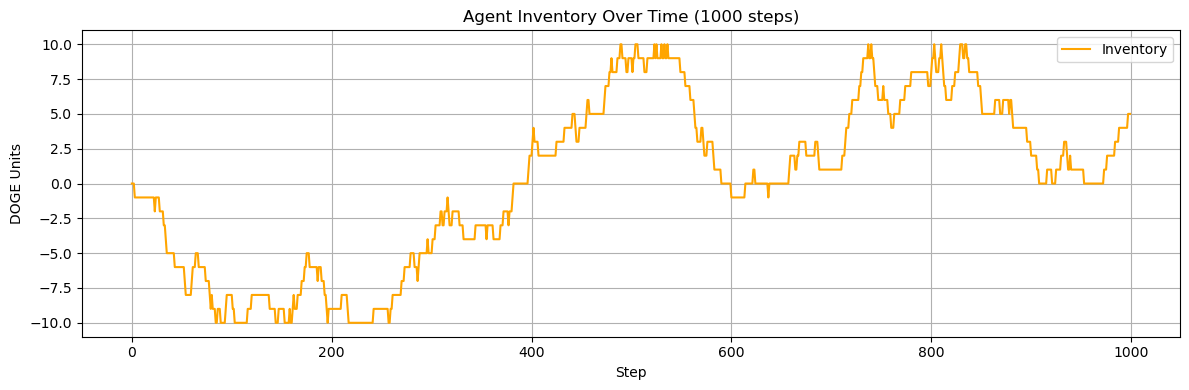

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(env_instance.pnl_history[:step_count], label="Net Worth (USDT)")
plt.title("Agent PnL Over Time (1000 steps)")
plt.xlabel("Step")
plt.ylabel("Net Worth")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(env_instance.inventory_history[:step_count], color='orange', label="Inventory")
plt.title("Agent Inventory Over Time (1000 steps)")
plt.xlabel("Step")
plt.ylabel("DOGE Units")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
